In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
%matplotlib inline
plt.style.use(style = 'ggplot')
plt.rcParams['figure.figsize'] = (10,6)

Change paths to files if need be...

In [35]:
# This will prompt for authorization.
from google.colab import drive

# Mount your drive. It will be at this path: "/content/gdrive/My Drive/"
drive.mount('/content/drive')


#%% Import Data
train = pd.read_csv('/content/drive/My Drive/ml_project/matt/train.csv')
test = pd.read_csv('/content/drive/My Drive/ml_project/matt/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Exploratory Data Analysis**

In [36]:
train.shape

(1460, 81)

In [37]:
test.shape

(1459, 80)

What column exists in `train` but not `test`

In [38]:
list(set(train) - set(test))

['SalePrice']

Well, that makes sense.

In [39]:
train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
519,520,70,RL,53.0,10918,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1926,2004,Gambrel,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,Gd,TA,No,Unf,0,Unf,0,1276,1276,GasA,...,Y,SBrkr,1276,804,0,2080,0,0,1,1,3,1,Gd,9,Typ,2,Gd,Detchd,1926.0,Unf,1,282,TA,TA,Y,0,0,0,0,145,0,NaN,MnPrv,NaN,0,6,2009,WD,Normal,234000
713,714,190,RL,60.0,9873,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Norm,2fmCon,1Story,4,5,1970,1970,Gable,CompShg,HdBoard,HdBoard,BrkFace,160.0,TA,TA,CBlock,TA,TA,Av,ALQ,789,Unf,0,171,960,GasW,...,N,SBrkr,960,0,0,960,1,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1970.0,Unf,2,576,TA,TA,Y,0,288,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,129000
1449,1450,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,5,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,553,Unf,0,77,630,GasA,...,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,Ex,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000
37,38,20,RL,74.0,8532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1954,1990,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,650.0,TA,TA,CBlock,TA,TA,No,Rec,1213,Unf,0,84,1297,GasA,...,Y,SBrkr,1297,0,0,1297,0,1,1,0,3,1,TA,5,Typ,1,TA,Attchd,1954.0,Fin,2,498,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,153000
607,608,20,RL,78.0,7800,Pave,NaN,Reg,Bnk,AllPub,Inside,Mod,Edwards,Norm,Norm,1Fam,2Story,5,8,1948,2002,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,Gd,No,GLQ,603,Unf,0,293,896,GasA,...,Y,SBrkr,1112,896,0,2008,1,0,3,0,3,1,Ex,8,Typ,0,NaN,Attchd,1948.0,Unf,1,230,TA,TA,Y,103,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal,225000
279,280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,2Story,7,5,1977,1977,Hip,CompShg,Plywood,Plywood,BrkFace,299.0,TA,TA,CBlock,Gd,TA,No,BLQ,392,Unf,0,768,1160,GasA,...,Y,SBrkr,1156,866,0,2022,0,0,2,1,4,1,TA,8,Typ,1,TA,Attchd,1977.0,Fin,2,505,TA,TA,Y,288,117,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,192000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1103,1104,20,RL,79.0,8910,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1959,1959,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,Mn,ALQ,655,Unf,0,0,655,GasA,...,Y,SBrkr,1194,0,0,1194,0,1,1,0,3,1,TA,6,Typ,1,Fa,BuiltIn,1954.0,Fin,2,539,TA,TA,Y,0,0,192,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,159500
494,495,30,RM,50.0,5784,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,8,1938,1996,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,190,190,GasA,...,Y,FuseA,886,0,0,886,0,0,1,0,2,1,TA,4,Typ,0,NaN,Attchd,1938.0,Unf,1,273,TA,TA,Y,144,20,80,0,0,0,NaN,NaN,NaN,0,12,2009,WD,Normal,91300
492,493,60,RL,105.0,15578,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,728

In [40]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Prefer working w/ lowercase colnames, making changes to both `train` and `test`

In [0]:
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

viewing target variable

In [42]:
train.saleprice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

graphing

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

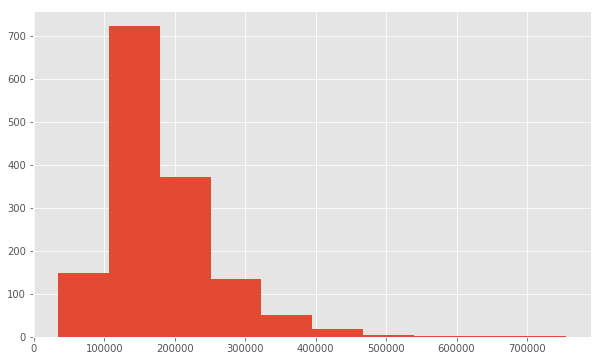

In [43]:
plt.hist(train.saleprice)

pretending i know how to understand `skew`

In [44]:
train.saleprice.skew()

1.8828757597682129

**Trying *log* transformation**

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

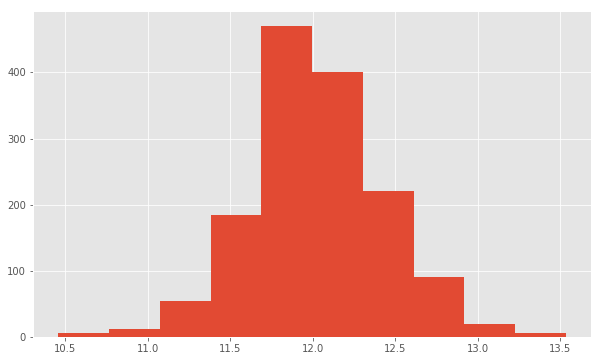

In [45]:
target = np.log(train.saleprice)
plt.hist(target)

In [46]:
target.skew()

0.12133506220520406

A `skew` of $0.1213$ is a lot better than $1.18828$

**Exploring Numeric Features**

In [0]:
numeric_features = train.select_dtypes(include = [np.number])
corr = numeric_features.corr()

Highest/Lowest Correlated Variables

In [48]:
print(corr.saleprice.sort_values(ascending = False)[1:10])
print('*'*15)
print(corr.saleprice.sort_values(ascending = False)[-10:])

overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
1stflrsf        0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
Name: saleprice, dtype: float64
***************
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64


**Working with `GarageArea`**

Text(0.5, 0, 'Garage Area')

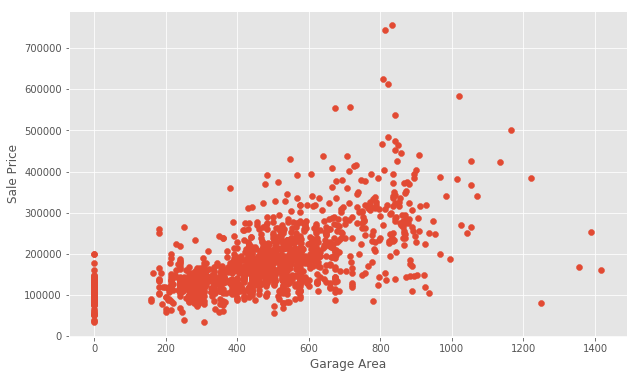

In [49]:
plt.scatter(train.garagearea, train.saleprice)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')

**Removing Outliers** from `GarageArea`

In [0]:
train = train[train.garagearea < 1200]

Graphing again....

Text(0.5, 0, 'Garage Area')

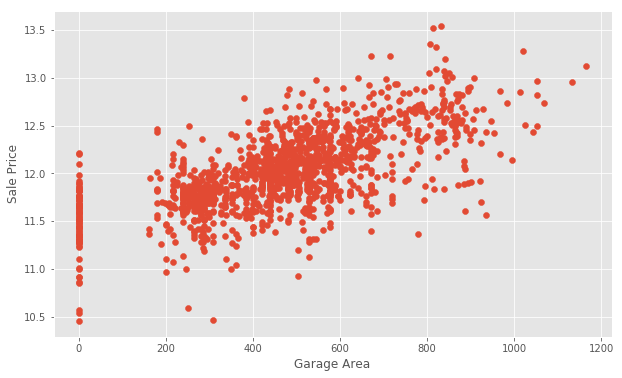

In [51]:
target = np.log(train.saleprice)
plt.scatter(train.garagearea, target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')

**Exploring `totalbsmtsf`**

Text(0.5, 0, 'Basement Sq. Feet')

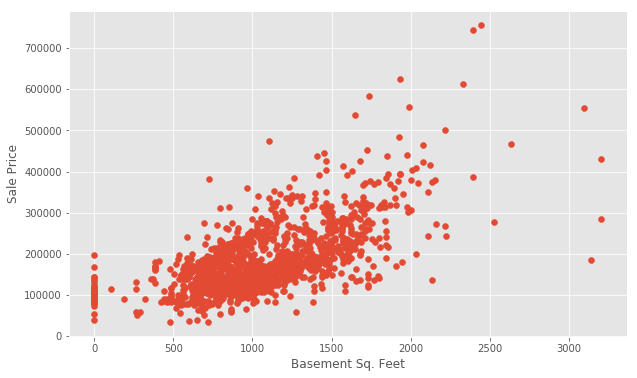

In [52]:
plt.scatter(train.totalbsmtsf, train.saleprice)
plt.ylabel('Sale Price')
plt.xlabel('Basement Sq. Feet')

removing outliers

In [0]:
train = train[train.totalbsmtsf < 2500]

**Exploring `1stflrsqft`**

Text(0.5, 0, 'First Floor Sq. Feet')

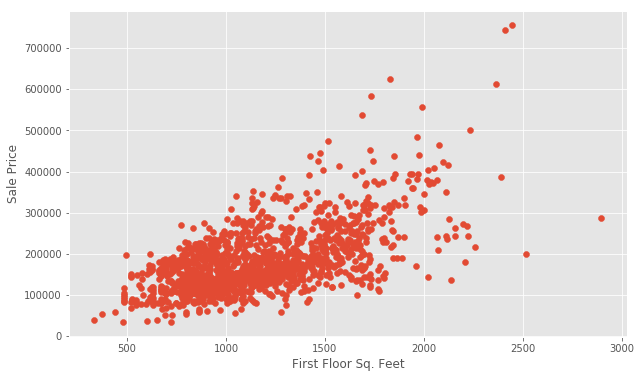

In [54]:
plt.scatter(train['1stflrsf'], train.saleprice)
plt.ylabel('Sale Price')
plt.xlabel('First Floor Sq. Feet')

**NULLS**

In [55]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))[train.isnull().sum().sort_values() > 0]
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Null Count
Feature,
poolqc,1443
miscfeature,1396
alley,1358
fence,1169
fireplacequ,689
lotfrontage,256
garagecond,81
garagetype,81
garageyrblt,81


**CATEGORICALS**

In [0]:
categoricals = train.select_dtypes(exclude = [np.number])

In [57]:
categoricals.describe()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1449,1449,91,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1441,1449,1449,1449,1412,1412,1411,1412,1412,1449,1449,1449,1448,1449,1449,760,1368,1368,1368,1368,1449,6,280,53,1449,1449
unique,5,2,2,4,4,2,5,3,25,9,7,5,8,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1141,1444,50,918,1304,1448,1042,1372,225,1253,1436,1210,717,1138,1425,511,500,861,905,1272,638,647,1300,948,428,1247,1417,732,1354,1323,733,1349,371,862,605,1300,1315,1329,2,156,48,1261,1191


In [58]:
categoricals[categoricals.columns[2]].value_counts()

Grvl    50
Pave    41
Name: alley, dtype: int64

In [59]:
for i in range(categoricals.shape[1]):
    print(categoricals.columns[i])
    print('\n')
    print(categoricals[categoricals.columns[i]].value_counts())
    print('*' * 20)

mszoning


RL         1141
RM          218
FV           65
RH           16
C (all)       9
Name: mszoning, dtype: int64
********************
street


Pave    1444
Grvl       5
Name: street, dtype: int64
********************
alley


Grvl    50
Pave    41
Name: alley, dtype: int64
********************
lotshape


Reg    918
IR1    481
IR2     41
IR3      9
Name: lotshape, dtype: int64
********************
landcontour


Lvl    1304
Bnk      61
HLS      50
Low      34
Name: landcontour, dtype: int64
********************
utilities


AllPub    1448
NoSeWa       1
Name: utilities, dtype: int64
********************
lotconfig


Inside     1042
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: lotconfig, dtype: int64
********************
landslope


Gtl    1372
Mod      64
Sev      13
Name: landslope, dtype: int64
********************
neighborhood


NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
Sawyer      74
NridgHt     73
NWAmes   

**Exploring `Street` Column**

In [60]:
train.street.value_counts()

Pave    1444
Grvl       5
Name: street, dtype: int64

encode to dummy

In [0]:
train['enc_street'] = pd.get_dummies(train.street, drop_first = True)

In [0]:
test['enc_street'] = pd.get_dummies(test.street, drop_first = True)

In [63]:
train['enc_street'].value_counts()

1    1444
0       5
Name: enc_street, dtype: int64

**Changing `Pool Area` to an `enc_pool` dummy**

In [64]:
train.poolarea.value_counts()

0      1443
738       1
648       1
576       1
555       1
519       1
512       1
Name: poolarea, dtype: int64

In [0]:
def encode(x): return 1 if x > 0 else 0
train['enc_pool'] = train.poolarea.apply(encode)
test['enc_pool'] = train.poolarea.apply(encode)

**Exploring `yrsold`**

In [66]:
train.yrsold.value_counts()

2009    334
2007    325
2006    314
2008    301
2010    175
Name: yrsold, dtype: int64

encoding to dummy `enc_after08`

In [0]:
def encode(x): return 1 if x > 2008 else 0
train['enc_after08'] = train.yrsold.apply(encode)
test['enc_after08'] = train.yrsold.apply(encode)

**Exploring `SALE CONDITION`**

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

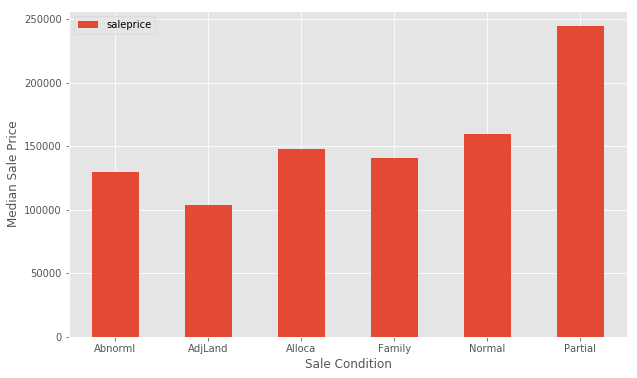

In [68]:
condition_pivot = train.pivot_table(index = 'salecondition', values = 'saleprice', aggfunc = np.median)
condition_pivot.plot(kind = 'bar')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)

In [69]:
from scipy import stats
partial = train.saleprice[train.salecondition == 'Partial']
not_partial = train.saleprice[train.salecondition != 'Partial']
stats.ttest_ind(partial, not_partial)

Ttest_indResult(statistic=14.665659932466808, pvalue=1.6621811304482718e-45)

*`PARTIAL`* has a sig. larger median sale price, making *`PARTIAL`* it's own dummyvar

In [0]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.salecondition.apply(encode)
test['enc_condition'] = test.salecondition.apply(encode)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

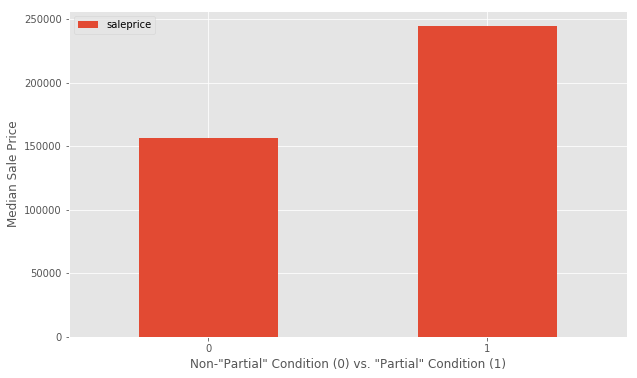

In [71]:
condition_pivot = train.pivot_table(index = 'enc_condition', values = 'saleprice', aggfunc = np.median)
condition_pivot.plot(kind = 'bar')
plt.xlabel('Non-"Partial" Condition (0) vs. "Partial" Condition (1)')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)

**INTERPOLATING REMAINING MISSING VALS W/ MEAN & DROPPING *NA* VALS**

In [0]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [73]:
sum(data.isnull().sum() != 0)

0

**LINEAR MODEL**

In [74]:
y = np.log(train.saleprice)
X = data.drop(['saleprice', 'id','poolarea'], axis = 1) #axis = 1, columns
X.sample(5)

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,miscval,mosold,yrsold,enc_street,enc_pool,enc_after08,enc_condition
412,20,78.0,4403,7,5,2009,2009,432.0,578,0,892,1470,1478,0,0,1478,1,0,2,1,2,1,7,1,2009.0,2,484,0,144,0,0,0,0,6,2010,1,0,1,1
395,20,68.0,9571,5,6,1956,1956,0.0,739,0,405,1144,1144,0,0,1144,1,0,1,0,3,1,6,0,1956.0,1,596,44,0,0,0,0,0,6,2010,1,0,1,0
68,30,47.0,4608,4,6,1945,1950,0.0,0,0,747,747,747,0,0,747,0,0,1,0,2,1,4,0,1945.0,1,220,0,0,0,0,0,0,6,2010,1,0,1,0
1239,20,64.0,9037,8,5,2006,2006,32.0,428,0,1048,1476,1484,0,0,1484,0,0,2,0,2,1,6,1,2006.0,2,472,120,33,0,0,0,0,12,2007,1,0,0,0
1340,20,70.0,8294,4,5,1971,1971,0.0,0,0,858,858,872,0,0,872,0,0,1,0,3,1,5,0,1974.0,4,480,0,0,0,0,0,0,6,2007,1,0,0,0


$80$/$20$ Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100, test_size = .2)

In [0]:
lm = linear_model.LinearRegression()

In [77]:
lm.fit(X_train,  y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
lm.score(X_test, y_test)

0.9127440875979633

The current linear model explains ~91% of the Log of Sale Price

In [79]:
predictions = lm.predict(X_test)
mean_squared_error(y_test, predictions)

0.013405719957236436

`MSE` is ~ $0.0134$

In [0]:
actual_values = y_test

Text(0, 0.5, 'Actual Log Price')

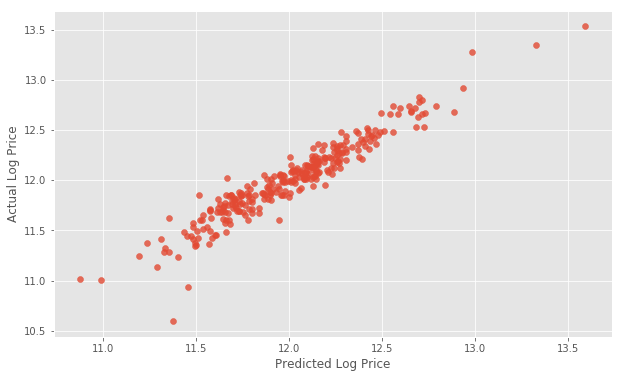

In [81]:
plt.scatter(predictions, actual_values, alpha = .8)
plt.xlabel('Predicted Log Price')
plt.ylabel('Actual Log Price')

Trying `xgboost` cuz, why not?

In [0]:
import xgboost

In [0]:
xgb = xgboost.XGBRegressor()

In [0]:
parameters = {'n_estimators': [600], 
              'min_child_weight': [0.5],
              'learning_rate': [0.03], 
              'gamma': [0.04], 
              'subsample': [0.8], 
              'max_depth': [5], 
              'reg_lambda': [0]}

In [0]:
from sklearn.model_selection import GridSearchCV
xgb.grid = GridSearchCV(xgb, parameters, cv = 3, n_jobs = 2)

In [86]:
xgb.grid.fit(X_train, y_train)
xgb.grid.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9046852923960597

In [87]:
predictions = xgb.grid.predict(X_test)
mean_squared_error(y_test, predictions)

0.014643847537309962

In [0]:
#xgb.fit(X_train, y_train)
#predictions = xgb.predict(X_test)
#mean_squared_error(y_test, predictions)

Text(0.5, 0, 'Actual Log Price')

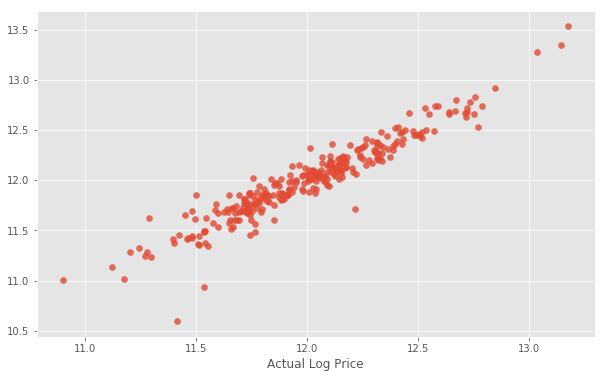

In [89]:
plt.scatter(predictions, actual_values, alpha = .8)
plt.xlabel('Predicted Log Price')
plt.xlabel('Actual Log Price')

**Creating a DataFrame of Sale Prices in the Kaggle `TEST` df**

In [0]:
df = pd.DataFrame()
df['Id'] = test.id

In [0]:
features = test.select_dtypes(include = [np.number]).drop(['id','poolarea'], axis = 1).interpolate()

In [0]:
xgb_predictions = xgb.grid.predict(features)

In [0]:
lm_predictions = lm.predict(features)

In [0]:
final_xgb_predictions = np.exp(xgb_predictions)

In [0]:
final_lm_predictions = np.exp(lm_predictions)

In [0]:
#df['LM_SalePrice'] = final_lm_predictions

In [0]:
df['SalePrice'] = final_xgb_predictions

In [98]:
df.head()

,Id,SalePrice
0,1461,125424.710938
1,1462,152896.453125
2,1463,174792.843750
3,1464,183378.484375
4,1465,186796.562500


In [0]:
#df['xgb_vs_lm'] = df.XGB_SalePrice/df.LM_SalePrice - 1

In [0]:
#df.xgb_vs_lm.describe()

In [0]:
#print('Largest Differences XGB > LM \n')
#print('*' * 40)
#print(df.xgb_vs_lm.sort_values(ascending = False)[:10])
#print('*' * 40)
#print('Largest Differences XGB < LM \n')
#print(df.xgb_vs_lm.sort_values(ascending = False)[-10:])
#print('*' * 40)

If you want it in csv...

In [0]:
df.to_csv('/content/drive/My Drive/ml_project/matt/xgbmodel.csv', index = False)